In [1]:
import numpy as np
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
# 特徴量選択
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# 多項式・交互作用特徴量
from sklearn.preprocessing import PolynomialFeatures
import math
# 評価関数（f1_score）
from sklearn.metrics import f1_score 
# 混同行列
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset, Dataset

## 訓練データの読み込み

In [3]:
class TrainDataset(Dataset):
    def __init__(self):
        super().__init__()
        # CSVファイル読み込み（訓練データ）
        df = pd.read_csv('train.csv')
        
        # 不正データの補正 (レコード削除のパターンもあるため、ファイル読み込み直後に処理する)
        df = self.correction(df)
        
        # 説明変数と目的変数に分割する
        df_x = df.drop(['loan_status'], axis=1)
        self.df_y = df.loc[:,['loan_status']]
        self.targetConv()
        
        # 説明変数の量的データ、質的データ分割
        self.x_cate , self.x_cont, self.x_id = self.DataChange(df_x.copy())
        self.x_desc = self.x_cont.describe()
        
        self.x_cate_conv = self.x_cate.copy()
        self.x_cont_conv = self.x_cont.copy()
        
        # データの加工（標準化や対数化など）
        #self.std_scale = 0
        #self.max_scale = 0
        #self.dobule_scale = 0
        #self.polynomialFlg = 0
        #self.binSplitFlg = 0
        self.logFlg = 0
        self.DataConv()
        
        #self.NpToPy()
        #self.num = len(self.X_train)
        self.num = len(self.X_train_cate)
        
    def __getitem__(self, index):
        return self.X_train_cate[index], self.X_train_cont[index], self.Y_train[index]
    
    def __len__(self):
        return self.num
    
    def correction(self, df):
        
        print('null check')
        print(df.isnull().sum())
        print('-------------------------')
        
        return df
    
    def viewDescribe(self):
        self.x_cont.describe()
        self.x_cate.describe(include='O')
    
    def dropCol(self):
        
        #self.x_cate_conv = self.x_cate_conv.drop(columns=['employment_length'], axis=1)
        self.x_cate_conv = self.x_cate_conv.drop(columns=['employment_length','application_type'], axis=1)
        # application_type  は使ってみる
        
        
        #self.x_cont_conv = self.x_cont_conv.drop(columns=['loan_amnt'], axis=1)
        self.x_cont_conv = self.x_cont_conv.drop(columns=['loan_amnt','credit_score'], axis=1)
        # credit_score  は使ってみる（差があるかは要確認）
        
    def DataChange(self, df_x):
        categ_cols = ['term' ,'grade' ,'employment_length', 'purpose' ,'application_type']
        contin_cols = ['loan_amnt', 'interest_rate', 'credit_score']
        index_cols = ['id']

        ####################################
        ##  データ分割
        ##  説明変数と目的変数に分ける。
        ##  説明変数はカテゴリデータと連続データに分ける。
        ####################################
        x_cate = df_x[categ_cols].copy()
        x_cont = df_x[contin_cols].copy()
        x_id = df_x[index_cols].copy()
        x_id = x_id.astype('int64')
        
        return x_cate , x_cont  ,x_id
    
    def targetConv(self):
        self.df_y = self.df_y.replace('FullyPaid', '0').replace('ChargedOff', '1')
        self.df_y.astype('float32')
        
    def NpToPy(self):
        
        #tmp = self.x_cont[['displacement_log', 'horsepower_log', 'weight_log', 'acceleration_log']]
        #tmp = self.x_cont[['horsepower_log', 'weight_log', 'acceleration_log']]

        # 訓練データと検証データに分割
        x_train_cate, x_test_cate ,y_train, y_test = train_test_split(self.x_cate_conv, self.df_y, test_size=0.2, random_state=3) 
        
        # カテゴリデータと同じ行数分数値データを抽出する
        row_index = x_train_cate.index.values
        x_train_cont = self.x_cont_conv.loc[row_index, :]
        row_index = x_test_cate.index.values
        x_test_cont = self.x_cont_conv.loc[row_index, :]
        
        # pandas.DataFrame を numpyに変換する
        x_train_cate = np.array(x_train_cate, dtype=np.float64)
        x_test_cate = np.array(x_test_cate, dtype=np.float64)
        x_train_cont = np.array(x_train_cont, dtype=np.float64)
        x_test_cont = np.array(x_test_cont, dtype=np.float64)
        y_train = np.array(y_train, dtype=np.float64)
        y_test = np.array(y_test, dtype=np.float64)
        
        
        # numpy の値を torch の値に変換する
        self.X_train_cate = torch.from_numpy(x_train_cate).float()
        self.X_train_cont = torch.from_numpy(x_train_cont).float()
        self.Y_train = torch.from_numpy(y_train).float()
        self.X_test_cate = torch.from_numpy(x_test_cate).float()
        self.X_test_cont = torch.from_numpy(x_test_cont).float()
        self.Y_test = torch.from_numpy(y_test).float()
        
        # 列数
        self.coti_size = self.X_train_cont.shape[1]
        self.cate_size  = self.X_train_cate.shape[1]
        self.in_size  = self.coti_size + self.cate_size
        self.out_size = self.Y_train.shape[1]  

        
    def termConv(self):
        
        col = 'term'
        
        self.x_cate_conv[col + '_1'] = 0

        row_index = self.x_cate.index[self.x_cate[col]=='3 years']
        self.x_cate_conv.loc[row_index, col + '_1'] = 1
        
        # ALL ゼロが5 yearsなので処理しない
        row_index = self.x_cate.index[self.x_cate[col]=='5 years']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
    
    def gradeConv(self):
        
        col = 'grade'
        
        self.x_cate_conv[col + '_01'] = 0
        self.x_cate_conv[col + '_02'] = 0
        self.x_cate_conv[col + '_03'] = 0
        self.x_cate_conv[col + '_04'] = 0
        self.x_cate_conv[col + '_05'] = 0
        
        self.x_cate_conv[col + '_06'] = 0
        self.x_cate_conv[col + '_07'] = 0
        self.x_cate_conv[col + '_08'] = 0
        self.x_cate_conv[col + '_09'] = 0
        self.x_cate_conv[col + '_10'] = 0
        
        self.x_cate_conv[col + '_11'] = 0
        self.x_cate_conv[col + '_12'] = 0
        self.x_cate_conv[col + '_13'] = 0
        self.x_cate_conv[col + '_14'] = 0
        self.x_cate_conv[col + '_15'] = 0
        
        self.x_cate_conv[col + '_16'] = 0
        self.x_cate_conv[col + '_17'] = 0
        self.x_cate_conv[col + '_18'] = 0
        self.x_cate_conv[col + '_19'] = 0
        self.x_cate_conv[col + '_20'] = 0        

        self.x_cate_conv[col + '_21'] = 0
        self.x_cate_conv[col + '_22'] = 0
        self.x_cate_conv[col + '_23'] = 0
        self.x_cate_conv[col + '_24'] = 0
        self.x_cate_conv[col + '_25'] = 0
        
        self.x_cate_conv[col + '_26'] = 0
        self.x_cate_conv[col + '_27'] = 0
        self.x_cate_conv[col + '_28'] = 0
        self.x_cate_conv[col + '_29'] = 0
            
        
        row_index = self.x_cate.index[self.x_cate[col]=='A1']
        self.x_cate_conv.loc[row_index, col + '_01'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='A2']
        self.x_cate_conv.loc[row_index, col + '_02'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='A3']
        self.x_cate_conv.loc[row_index, col + '_03'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='A4']
        self.x_cate_conv.loc[row_index, col + '_04'] = 1        
        row_index = self.x_cate.index[self.x_cate[col]=='A5']
        self.x_cate_conv.loc[row_index, col + '_05'] = 1     

        row_index = self.x_cate.index[self.x_cate[col]=='B1']
        self.x_cate_conv.loc[row_index, col + '_06'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='B2']
        self.x_cate_conv.loc[row_index, col + '_07'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='B3']
        self.x_cate_conv.loc[row_index, col + '_08'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='B4']
        self.x_cate_conv.loc[row_index, col + '_09'] = 1        
        row_index = self.x_cate.index[self.x_cate[col]=='B5']
        self.x_cate_conv.loc[row_index, col + '_10'] = 1  
 
        row_index = self.x_cate.index[self.x_cate[col]=='C1']
        self.x_cate_conv.loc[row_index, col + '_11'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='C2']
        self.x_cate_conv.loc[row_index, col + '_12'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='C3']
        self.x_cate_conv.loc[row_index, col + '_13'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='C4']
        self.x_cate_conv.loc[row_index, col + '_14'] = 1        
        row_index = self.x_cate.index[self.x_cate[col]=='C5']
        self.x_cate_conv.loc[row_index, col + '_15'] = 1     

        row_index = self.x_cate.index[self.x_cate[col]=='D1']
        self.x_cate_conv.loc[row_index, col + '_16'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='D2']
        self.x_cate_conv.loc[row_index, col + '_17'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='D3']
        self.x_cate_conv.loc[row_index, col + '_18'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='D4']
        self.x_cate_conv.loc[row_index, col + '_19'] = 1        
        row_index = self.x_cate.index[self.x_cate[col]=='D5']
        self.x_cate_conv.loc[row_index, col + '_20'] = 1  
        
        row_index = self.x_cate.index[self.x_cate[col]=='E1']
        self.x_cate_conv.loc[row_index, col + '_21'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='E2']
        self.x_cate_conv.loc[row_index, col + '_22'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='E3']
        self.x_cate_conv.loc[row_index, col + '_23'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='E4']
        self.x_cate_conv.loc[row_index, col + '_24'] = 1        
        row_index = self.x_cate.index[self.x_cate[col]=='E5']
        self.x_cate_conv.loc[row_index, col + '_25'] = 1     

        row_index = self.x_cate.index[self.x_cate[col]=='F1']
        self.x_cate_conv.loc[row_index, col + '_26'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='F2']
        self.x_cate_conv.loc[row_index, col + '_27'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='F3']
        self.x_cate_conv.loc[row_index, col + '_28'] = 1
        row_index = self.x_cate.index[self.x_cate[col]=='F4']
        self.x_cate_conv.loc[row_index, col + '_29'] = 1        
        
        # ALL ゼロがF5なので処理しない
        row_index = self.x_cate.index[self.x_cate[col]=='F5']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
        
        
    def purposeConv(self):
        
        col = 'purpose'
        
        self.x_cate_conv[col + '_1'] = 0
        self.x_cate_conv[col + '_2'] = 0
        self.x_cate_conv[col + '_3'] = 0
        self.x_cate_conv[col + '_4'] = 0
        self.x_cate_conv[col + '_5'] = 0
        self.x_cate_conv[col + '_6'] = 0 
        self.x_cate_conv[col + '_7'] = 0
        self.x_cate_conv[col + '_8'] = 0
        
        row_index = self.x_cate.index[self.x_cate[col]=='car']
        self.x_cate_conv.loc[row_index, col + '_1'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='credit_card']
        self.x_cate_conv.loc[row_index, col + '_2'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='debt_consolidation']
        self.x_cate_conv.loc[row_index, col + '_3'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='home_improvement']
        self.x_cate_conv.loc[row_index, col + '_4'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='house']
        self.x_cate_conv.loc[row_index, col + '_5'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='major_purchase']
        self.x_cate_conv.loc[row_index, col + '_6'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='medical']
        self.x_cate_conv.loc[row_index, col + '_7'] = 1
        
        row_index = self.x_cate.index[self.x_cate[col]=='small_business']
        self.x_cate_conv.loc[row_index, col + '_8'] = 1
        
        # ALL ゼロがotherなので処理しない
        row_index = self.x_cate.index[self.x_cate[col]=='other']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
        
    def appConv(self):
        
        col = 'application_type'
        
        self.x_cate_conv[col + '_1'] = 0

        row_index = self.x_cate.index[self.x_cate[col]=='Individual']
        self.x_cate_conv.loc[row_index, col + '_1'] = 1
        
        # ALL ゼロがJoint Appなので処理しない
        row_index = self.x_cate.index[self.x_cate[col]=='Joint App']
        
        self.x_cate_conv = self.x_cate_conv.drop(columns=col ,axis=1)
 
    def binSplit(self):
        contin_cols = self.x_cont_conv.columns.values

        for col in contin_cols:
            split_min = 0
            split_min2 = self.x_desc.loc['min',col]
            split1 = self.x_desc.loc['25%',col]
            split2 = self.x_desc.loc['50%',col]
            split3 = self.x_desc.loc['75%',col]
            std_m = self.x_desc.loc['std',col]/3
            std_p = self.x_desc.loc['std',col]*3
            split_max=  self.x_desc.loc['max',col]
            split_max2=  self.x_desc.loc['max',col]*10
            bins = [split_min,  split_min2, split1,  split2,  split3, std_m,  std_p,  split_max, split_max2]
            bins = np.sort(bins)
            self.x_cont_conv[col] = pd.cut(self.x_cont_conv[col], bins=bins, labels=False)
    
    def binSplit2(self):
        contin_cols = self.x_cont_conv.columns.values

        for col in contin_cols:
            
            bins = 30
            self.x_cont_conv[col] = pd.cut(self.x_cont_conv[col], bins=bins ,labels=False)
            
    def DataConv(self):

        self.termConv()
        self.gradeConv()
        self.purposeConv()
        #self.appConv()
        #self.binSplit2()
        self.dropCol()        
        self.NpToPy()
        

In [4]:
train_dataset = TrainDataset()

null check
id                   0
loan_amnt            0
term                 0
interest_rate        0
grade                0
employment_length    0
purpose              0
credit_score         0
application_type     0
loan_status          0
dtype: int64
-------------------------


In [5]:
class TestDataset(TrainDataset):
    def __init__(self, x_desc):
        
        # CSVファイル読み込み（訓練データ）
        df = pd.read_csv('test.csv' )
        self.df_data = df.copy()
        # 不正データの補正 (レコード削除のパターンもあるため、ファイル読み込み直後に処理する)
        df = self.correction(df)
        
        # 目的変数の格納
        self.x_cate , self.x_cont, self.x_id = self.DataChange(df.copy())
        self.x_desc = x_desc
        
        self.x_cate_conv = self.x_cate.copy()
        self.x_cont_conv = self.x_cont.copy()
        
        # データの加工（標準化や対数化など）
        #self.std_scale = 0
        #self.max_scale = 0
        #self.dobule_scale = 0
        #self.polynomialFlg = 0
        #self.binSplitFlg = 0
        self.logFlg  = 0
        self.DataConv()
        
        #self.NpToPy()
        #self.num = len(self.x_cate)
        self.num = len(self.x_cate_conv)
        self.coti_size = self.x_cont_conv.shape[1]

    def __getitem__(self, index):
        return self.X_vat[index]
    
    def __len__(self):
        return self.num
    
    def NpToPy(self):
        
        #x_temp = self.x_cont.copy()
        tmp_cate = np.array(self.x_cate_conv)
        tmp_cont = np.array(self.x_cont_conv)
        
        # numpy の値を torch の値に変換する
        self.X_vat_cate = torch.from_numpy(tmp_cate).float()
        self.X_vat_cont = torch.from_numpy(tmp_cont).float()
 


## 評価データの読み込み

In [6]:
test_dataset = TestDataset(train_dataset.x_desc)

null check
id                   0
loan_amnt            0
term                 0
interest_rate        0
grade                0
employment_length    0
purpose              0
credit_score         0
application_type     0
dtype: int64
-------------------------


In [7]:
test_dataset.x_cont.describe()

,loan_amnt,interest_rate,credit_score
count,26900.000000,26900.000000,26900.000000
mean,1515.095458,13.778459,683.840319
std,827.710449,4.587711,29.685781
min,353.090088,5.745858,655.435675
25%,753.766957,10.846102,659.589762
50%,1213.754480,13.551492,678.707870
75%,2147.699462,17.128929,698.684676
max,3812.969623,27.503147,811.676356


In [8]:
len(train_dataset)

193720

In [9]:
train_dataset.in_size

39

# モデル定義（分類）

In [10]:
batchsize=500

# batch_size ：学習する時にまとめるデータ数
# shuffle    : データをランダムに並び替える場合はTrue
#train_loader = DataLoader(train ,batch_size=30, shuffle=True, num_workers=2)
train_loader = DataLoader(dataset=train_dataset ,batch_size=batchsize, shuffle=True)

In [11]:
node1=25
node2=8


# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net1(nn.Module):
    # 初期化の関数
    def __init__(self):
        super(Net1 ,self).__init__()
        # ドロップアウト
        p=0.5
        self.dropout1 = nn.Dropout(p)
        self.dropout2 = nn.Dropout(p)
        
        # バッチ正規化
        self.bn_cont = nn.BatchNorm1d(train_dataset.coti_size)
        
        # 全結合層
        self.fc1 = nn.Linear(train_dataset.in_size , node1)         # nn.Linear (入力のノード数 , 中間層ノード数)
        self.fc2 = nn.Linear(node1 , node2)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc3 = nn.Linear(node2,  train_dataset.out_size)        # nn.Linear (中間層ノード数 , 出力のノード数)
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x_cate, x_cont):
#        x = torch.relu(self.fc1(x))              # 入力のノードを中間層（１階層目）に渡して結果を得る
#        x = F.sigmoid(self.fc2(x))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る

        # バッチ正規化
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x_cate, x_cont], 1)
        
        x = torch.sigmoid (self.fc1(x))           # 入力のノードを中間層（１階層目）に渡して結果を得る
        x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))           # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))           # 中間層（２階層目）の結果を出力層に渡す
        return x

In [12]:
# モデルの定義
model1 = Net1()
# 損失の定義
criterion1 = nn.BCELoss()
# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）
optimizer1 = optim.Adam(model1.parameters() , lr=0.005)

In [14]:
loss_list1 = []
accuracy_list1 = []

correct_counter1 = 0
logdisp=1
#acccnt=len(train_dataset)*logdisp
acccnt=batchsize*logdisp
print('rec_cnt', acccnt)
epochs=50
mathcnt = 0

# トレーニングの回数分ループする。
for epoch in range(epochs):
    # 損失を初期化　
    total_loss1 = 0
    
    for x_train_cate, x_train_cont, y_train in train_loader:

        # 出力を計算する 
        output1 = model1(x_train_cate, x_train_cont)
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss1 = criterion1(output1 ,y_train)
        
        #correct_temp = roc_auc_score(y_true=y_train.numpy(), y_score=output1.data.numpy())
        correct_temp = 0
        correct_counter1 += correct_temp
        mathcnt += 1

        
        # パラメータの勾配を初期化する
        optimizer1.zero_grad()
        # ロスを伝播する
        loss1.backward()
        # パラメータを更新する
        optimizer1.step()

        # トータルロスを格納
        total_loss1 += loss1.item()

    
    # 回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_tmp1=total_loss1/acccnt
        print(f'Epoch\t{epoch+1}\tLoss\t{loss_tmp1:.8f}\taccu:\t{correct_counter1*100/mathcnt:.3f}%')
        
        
        #accuracy_list1.append(correct_counter1.item()*100/(mathcnt))
        loss_list1.append(loss_tmp1)
        total_loss=0
        correct_counter1 = 0
        mathcnt = 0
        

rec_cnt 50
Epoch	1	Loss	33.68708271	accu:	0.000%
Epoch	2	Loss	33.64774804	accu:	0.000%
Epoch	3	Loss	33.63661707	accu:	0.000%
Epoch	4	Loss	33.66890521	accu:	0.000%
Epoch	5	Loss	33.59885868	accu:	0.000%
Epoch	6	Loss	33.63007436	accu:	0.000%
Epoch	7	Loss	33.58550673	accu:	0.000%
Epoch	8	Loss	33.58657906	accu:	0.000%
Epoch	9	Loss	33.57775635	accu:	0.000%
Epoch	10	Loss	33.60345504	accu:	0.000%
Epoch	11	Loss	33.56510523	accu:	0.000%
Epoch	12	Loss	33.59066378	accu:	0.000%
Epoch	13	Loss	33.61363803	accu:	0.000%
Epoch	14	Loss	33.56823189	accu:	0.000%
Epoch	15	Loss	33.56814406	accu:	0.000%
Epoch	16	Loss	33.56096970	accu:	0.000%
Epoch	17	Loss	33.62002007	accu:	0.000%
Epoch	18	Loss	33.56195266	accu:	0.000%
Epoch	19	Loss	33.58083704	accu:	0.000%
Epoch	20	Loss	33.58844069	accu:	0.000%
Epoch	21	Loss	33.57215877	accu:	0.000%
Epoch	22	Loss	33.57036134	accu:	0.000%
Epoch	23	Loss	33.58046778	accu:	0.000%
Epoch	24	Loss	33.58748815	accu:	0.000%
Epoch	25	Loss	33.60037285	accu:	0.000%
Epoch	26	Loss	33.597573

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


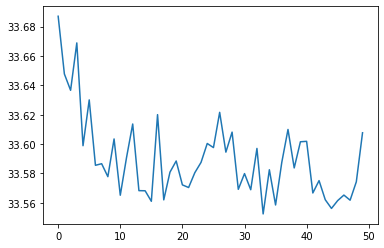

In [15]:
# ロスのプロット
plt.plot(loss_list1)

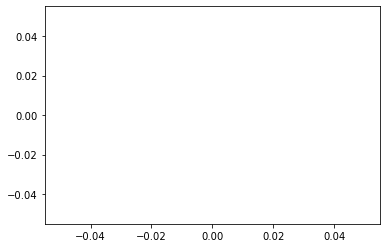

In [16]:
plt.plot(accuracy_list1)

# 予測精度の確認

## 訓練データ 

In [17]:
# 学習を行わないモードに変更
model1.eval()

Net1(
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=39, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)

In [19]:
y_pred_train=model1(train_dataset.X_train_cate, train_dataset.X_train_cont).data
df_pred_train = pd.DataFrame(y_pred_train.numpy())
print(df_pred_train)


                     0
0       tensor(0.1741)
1       tensor(0.1716)
2       tensor(0.1328)
3       tensor(0.1363)
4       tensor(0.1566)
...                ...
193715  tensor(0.1348)
193716  tensor(0.1822)
193717  tensor(0.1470)
193718  tensor(0.2067)
193719  tensor(0.2371)

[193720 rows x 1 columns]


               0
0       0.174141
1       0.171629
2       0.132780
3       0.136274
4       0.156589
...          ...
193715  0.134837
193716  0.182211
193717  0.146986
193718  0.206675
193719  0.237116

[193720 rows x 1 columns]


In [33]:
# 予測結果から閾値の算出
chargedoff_val = train_dataset.Y_train.sum()
chargedoff_val = int(chargedoff_val)
proba_desc = df_pred_train[0].sort_values(ascending = False)
threshold = proba_desc.iat[chargedoff_val]
print(threshold)


def classification(x):
    #print(len(x))
    
    if (x.ndim == 1)and (len(x) == 1):
        if x >= threshold:
            return 1
        else:
            return 0
    else:
        tmp = np.zeros(len(x) ,dtype=np.int32)
        for i in range(len(x)):
            if x[i] >= threshold:
                tmp[i] = 1
            
        return tmp

        

0.28275996


In [36]:
pred_tmp = classification(np.array(df_pred_train[0]))
score_train = f1_score(train_dataset.Y_train, pred_tmp)
# f1_scoreの表示
print(score_train)

0.35625082936466984


In [37]:
# 混同行列
confusion_matrix(train_dataset.Y_train, pred_tmp)

array([[137978,  21831],
       [ 21830,  12081]], dtype=int64)

In [38]:
print(classification_report(train_dataset.Y_train, pred_tmp))

              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86    159809
         1.0       0.36      0.36      0.36     33911

    accuracy                           0.77    193720
   macro avg       0.61      0.61      0.61    193720
weighted avg       0.77      0.77      0.77    193720



## 検証データ

In [39]:
y_pred_test=model1(train_dataset.X_test_cate, train_dataset.X_test_cont).data
df_pred_test = pd.DataFrame(y_pred_test.numpy())
print(df_pred_test)


              0
0      0.293091
1      0.253157
2      0.131809
3      0.022470
4      0.120276
...         ...
48425  0.177683
48426  0.290260
48427  0.123762
48428  0.132536
48429  0.291412

[48430 rows x 1 columns]


In [40]:
pred_tmp = classification(np.array(df_pred_test[0]))
score_test = f1_score(train_dataset.Y_test, pred_tmp)
# f1_scoreの表示
print(score_test)

0.35946736728966383


In [42]:
# 混同行列
confusion_matrix(train_dataset.Y_test, pred_tmp)

array([[34693,  5292],
       [ 5435,  3010]], dtype=int64)

In [43]:
print(classification_report(train_dataset.Y_test, pred_tmp))

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87     39985
         1.0       0.36      0.36      0.36      8445

    accuracy                           0.78     48430
   macro avg       0.61      0.61      0.61     48430
weighted avg       0.78      0.78      0.78     48430



#  予測する

In [44]:
y_predict=model1(test_dataset.X_vat_cate, test_dataset.X_vat_cont).data
df_predict = pd.DataFrame(y_predict.numpy())
y_predict = classification(np.array(df_predict[0]))

df_out = pd.DataFrame(y_predict, columns=['val'])
df_out = pd.concat([test_dataset.x_id['id'] ,df_out['val']] , axis=1)
df_out.to_csv('./submit.csv', encoding='utf_8_sig' , header=False ,index=False)
df_out




,id,val
0,242150,0
1,242151,1
2,242152,0
3,242153,0
4,242154,0
...,...,...
26895,269045,0
26896,269046,0
26897,269047,0
26898,269048,0


# モデルの保存

In [46]:
#model_path = 'model1.pth'
#torch.save(model1.to('cpu').state_dict(), model_path)
